<a href="https://colab.research.google.com/github/crismaque/Se-nales_y_Sistemas_2023_II/blob/main/Fourier/Shazam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Detector de género de canciones



1. Cargar base de datos
2. Importar/Descargar librerías para manejo de señales de audio
3. Leer base de datos
4. Procesar la BBDD
5. Almacenar espectros
6. Ingresar enlace de prueba
7. Aplicar Fourier
8. Comparar espectro con Cdist
9. Obtener argmin
10. Clasificar



#Tratamiento de la base de datos

* Eliminar carpetas innecesarias

In [ ]:
try:
    shutil.rmtree('results/')
    print('Entorno eliminado')
except:
    print('No ha sido posible reiniciar el entorno')

No ha sido posible reiniciar el entorno


* Instalación e importe de librerías

In [ ]:
!python3 -m pip install --force-reinstall -U https://github.com/yt-dlp/yt-dlp/archive/master.tar.gz

In [ ]:
!pip install soundfile

In [ ]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import yt_dlp as youtube_dl
import soundfile as sf
import os
import subprocess
from IPython.display import Audio
import shutil
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance

* Carga del modelo

In [ ]:
filename_ = 'modelo/trap_vs_salsa'
my_model_loaded = joblib.load(filename_+".pkl")
my_model_loaded.keys()

dict_keys(['Xw_', 'fmax', 'label', 'name_c', 'vf', 'fs'])

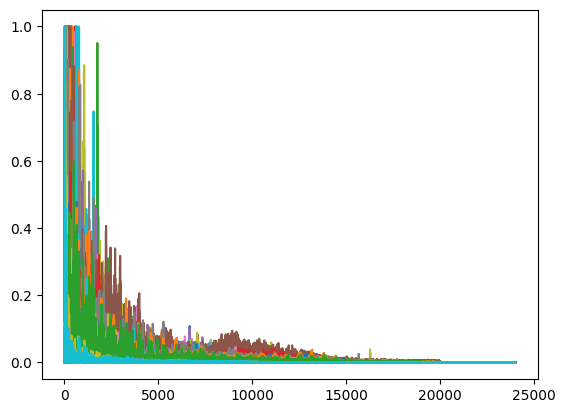

In [ ]:
x_t = my_model_loaded['Xw_']
vf = my_model_loaded['vf']
gen = my_model_loaded['label']
band = my_model_loaded['name_c']
plt.plot(vf, x_t.T)
plt.show()

* Función de descarga de audios

In [ ]:
#funcion para descargar mp3 desde youtube
def download_ytvid_as_mp3(video_url,name):
    #video_url = input("enter url of youtube video:")
    video_info = youtube_dl.YoutubeDL().extract_info(url = video_url,download=False)
    filename = f"{name}.mp3"
    options={
        'format':'bestaudio/best',
        'keepvideo':False,
        'outtmpl':filename,
    }

    with youtube_dl.YoutubeDL(options) as ydl:
        ydl.download([video_info['webpage_url']])

    print("Download complete... {}".format(filename))

* Conversión de formato a .wav

In [ ]:
#crear carpeta con resultados
try:
    shutil.rmtree(f'pruebas')
    print('Archivo removido con éxito\n')
    os.mkdir('pruebas')
except:
    print("Carpeta pruebas ya existe")

#recorrer excel con videos
x_input = [{'link': 'https://www.youtube.com/watch?v=4LfJnj66HVQ', 'band': 'Lil_Pump', 'type': 'Trap', 'type_num': '1'}, {'link': 'https://www.youtube.com/watch?v=hLKwsJHspCw', 'band': 'El_Gran_Combo_De_PR', 'type': 'Salsa', 'type_num': '2'}]
N = len(x_input) # Filas, Columnas
Ns = N * 5 # Cantidad de segmentos por cancion

for n in range(N):
    print(f"video {n+1} de {N}")
    print(f"link: {x_input[n]['link']}")
    print(f"band: {x_input[n]['band']}")
    print(f"type: {x_input[n]['type']}")
    #ruta video n-th
    name_ = 'pruebas/'+x_input[n]['type']+"_"+str(n)+"_"+str(x_input[n]['type_num']) # #video+nombre+tipo de genero musical
    #descargar mp3 desde youtube
    download_ytvid_as_mp3(x_input[n]['link'], name_)
    #convertir a .wav
    subprocess.call(['ffmpeg','-y', '-i', name_+'.mp3', name_+'.wav'])

    # Eliminar archivos innecesarios
    try:
        os.remove(f'{name_}.mp3')
        print('Archivo removido con éxito\n')
    except:
        print('El archivo ya ha sido removido\n')

* Archivos .wav almacenados en una lista

In [ ]:
path = 'pruebas/'
wav_files = [f for f in os.listdir(path)]
wav_files

['Trap_0_1.wav', 'Salsa_1_2.wav']

* Vector de datos de canciones

In [ ]:
fs = 48000 # Frecuencia de muestreo de YouTube
tl = np.array([40,50,60,70,80,90,100]) # Puntos de lectura (segundos en los que leerá el espectro de la canción)
ts = 5 # Duración de la muestra)
Ns = len(wav_files) * len(tl) # cantidad de muestras

x_a = np.zeros((Ns, int(ts*fs), 2)) #Ns filas, ts*fs columnas, 2 canales (stereo) por elemento
label = np.zeros((Ns, 1)) #vector tipo de genero
name_c = [] # Vector de nombres de las canciones

#leer archivos wav
i = 0 # Contador
for song in wav_files: # lectura audio .wav
    x, fs = sf.read(path+song) # song data, frecuencia de muestreo
    for lect in tl: #segmentos de tiempo
        x_a[i] = x[int(fs*lect):int(fs*(lect+ts)),:] # Guarda la muestra en el vector de songs data
        label[i] = int(song[-5]) # Guarda el tipo de genero
        name_c += [song[:-6]] # Guarda el nombre de la canción
        print(f"{i} lectura: {song}; segundo {lect}:{lect+ts}; tipo música {label[i]}")
        i+=1
x_a.shape

0 lectura: Trap_0_1.wav; segundo 40:45; tipo música [1.]
1 lectura: Trap_0_1.wav; segundo 50:55; tipo música [1.]
2 lectura: Trap_0_1.wav; segundo 60:65; tipo música [1.]
3 lectura: Trap_0_1.wav; segundo 70:75; tipo música [1.]
4 lectura: Trap_0_1.wav; segundo 80:85; tipo música [1.]
5 lectura: Trap_0_1.wav; segundo 90:95; tipo música [1.]
6 lectura: Trap_0_1.wav; segundo 100:105; tipo música [1.]
7 lectura: Salsa_1_2.wav; segundo 40:45; tipo música [2.]
8 lectura: Salsa_1_2.wav; segundo 50:55; tipo música [2.]
9 lectura: Salsa_1_2.wav; segundo 60:65; tipo música [2.]
10 lectura: Salsa_1_2.wav; segundo 70:75; tipo música [2.]
11 lectura: Salsa_1_2.wav; segundo 80:85; tipo música [2.]
12 lectura: Salsa_1_2.wav; segundo 90:95; tipo música [2.]
13 lectura: Salsa_1_2.wav; segundo 100:105; tipo música [2.]


(14, 240000, 2)

* Procesado por Fourier

In [ ]:
#calculo de fourier
vf = np.fft.rfftfreq(x_a.shape[1],1/fs) #calculo vector de frecuencias
X_a = np.fft.rfft(x_a, axis=1).mean(axis=-1) #transformada rapida de Fourier para señal Real a lo largo del tiempo (axis=1 -> filas) y se promedian los dos canales
X_a.shape

(14, 120001)

* Ploteo de las pruebas

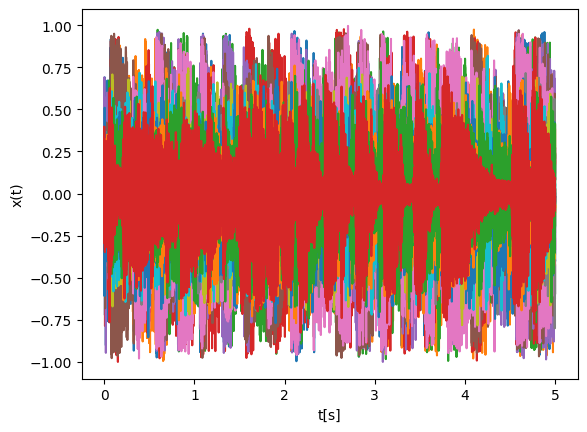

In [ ]:
#grafica tiempo y fourier
plt.plot(np.arange(0,ts,1/fs), x_a.mean(axis=-1).T) #se promedian los dos canales stereo
plt.xlabel('t[s]')
plt.ylabel('x(t)')
plt.show()

* Normalizar espectros

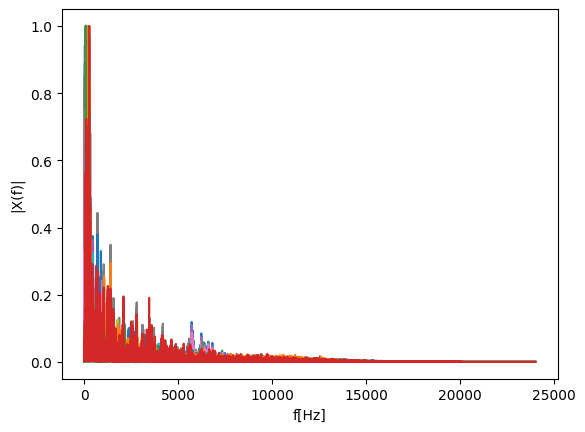

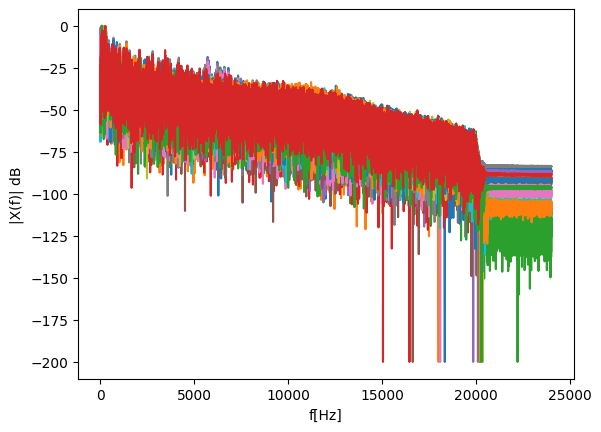

In [ ]:
#se normalizan espectros entre 0 y 1 para evitar inconsistencias por ampliltudes máximas
sca = MinMaxScaler()
Xw_ = sca.fit_transform(abs(X_a).T).T

plt.plot(vf,Xw_.T)
plt.xlabel('f[Hz]')
plt.ylabel('|X(f)|')
plt.show()

#en dB
plt.plot(vf,(20*np.log10(Xw_+1e-10)).T) # se suma 1e-10 para evitar discontinuidad del log
plt.xlabel('f[Hz]')
plt.ylabel('|X(f)| dB')
plt.show()

* Dispersión de las muestras

In [ ]:
#visualización de datos
# red_ = TSNE(perplexity = 20,n_components=2,random_state=123,learning_rate='auto',init='pca')
red_ = PCA(n_components=2,random_state=123)
fmax = 7000
X_2D = red_.fit_transform(Xw_[:,:fmax]) #se tiene en cuenta el espectro hasta fmax Hz

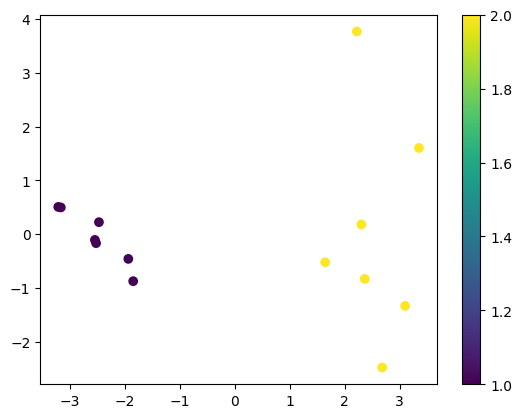

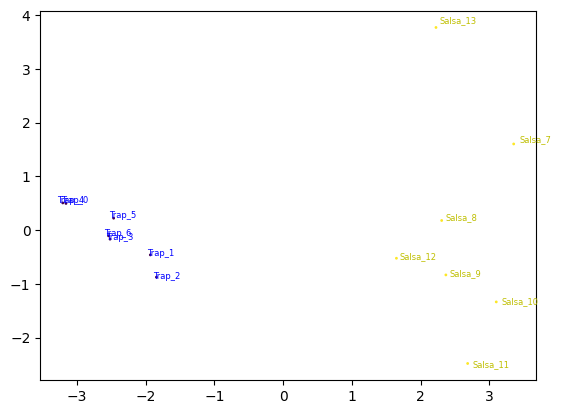

In [ ]:
#graficar separabilidad 2D
plt.scatter(X_2D[:,0],X_2D[:,1],c=label)
plt.colorbar()
plt.show()

color_ = ["b","y"]
#nombre cancion
plt.scatter(X_2D[:,0],X_2D[:,1],c=label,s=1)
for i, tex in enumerate(name_c):
    #print(f"{i} {tex}")
    plt.text(X_2D[i,0]*1.025,X_2D[i,1]*1.025, tex[:-2]+"_"+str(i), fontsize=6,color=color_[int(label[i]-1)])

#plt.colorbar()
plt.show()

# Comparación de espectros (Shazam)

* Análisis de Coincidencias

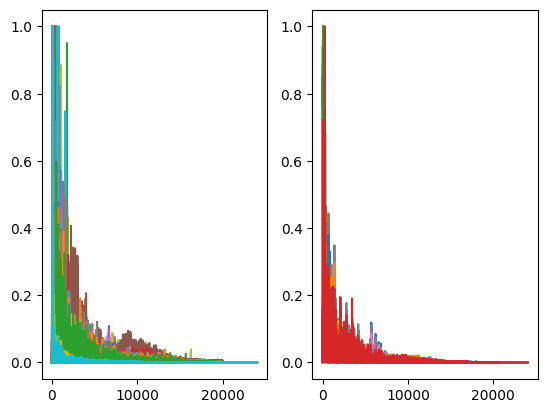

In [ ]:
plt.subplot(1,2,1)
plt.plot(vf, x_t.T)
plt.subplot(1,2,2)
plt.plot(vf, Xw_.T)
plt.show()

In [ ]:
from scipy.spatial.distance import cdist

distance = cdist(x_t, Xw_[:7]) # Para la canción 1 Xw_[:7], para la canción 2 Xw_[7:]
v = np.argmin(distance, axis=0)

gender = {'Trap': 0, 'Salsa': 0}
for ind in v:
    if gen[ind] == 1:
        gender['Trap'] += 1
    else:
        gender['Salsa'] += 1

print(f'La canción analizada fue: {x_input[0]["band"]}\n'+
f'Su género es: {x_input[0]["type"]}\n\n'+
f'Se predijo el género: {"Trap" if gender["Trap"] > gender["Salsa"] else "Salsa"}\n')

La canción analizada fue: Lil_Pump
Su género es: Trap

Se predijo el género: Trap

